In [1]:
import numpy as np
import pandas as pd

In [2]:
df_test = pd.read_csv('titanic_test.csv')
df_train = pd.read_csv('titanic_train.csv')


In [3]:
df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Adding the Survived col to the test df too with NaN values

In [10]:
X_test=df_test.copy()
X_test['Survived'] = -1
X_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,-1


In [12]:
X_train = df_train.copy()
X_train['source'] = 'train'
X_test['source'] = 'test'
combined_df = pd.concat([X_train,X_test]).reset_index(drop=True)
combined_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,source
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


### Combined the two files to perform preprocessing on whole

In [15]:
combined_df.isnull().sum()


PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
source            0
dtype: int64

In [17]:
print(combined_df['Embarked'].value_counts())

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64


## Preprocessing Piepline

In [20]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def encode_sex(df):
    df=df.copy()
    df['Sex'] = df['Sex'].map({'male':0, 'female':1})
    return df

def encode_embarked(df):
    df = df.copy()
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df = pd.get_dummies(df, columns=['Embarked'], drop_first = True)
    df[['Embarked_Q', 'Embarked_S']] = df[['Embarked_Q', 'Embarked_S']].astype(int)
    return df

# FamilySize = SibSp + Parch + 1 (including the passenger)
def add_family_size(df):
    df = df.copy()
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

def add_is_alone(df):
    df = df.copy()
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    return df


preproc_pipeline = Pipeline(steps=
                            [('encode_sex',FunctionTransformer(encode_sex,validate = False)),
                             ('encode_embarked', FunctionTransformer(encode_embarked, validate= False)),
                             ('family_size', FunctionTransformer(add_family_size, validate=False)),
                             ('is_alone', FunctionTransformer(add_is_alone, validate=False)),
                            ])

    

In [21]:
clean_combined = preproc_pipeline.fit_transform(combined_df)
clean_combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,train,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,train,0,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,train,0,1,1,1


In [22]:
clean_combined.isnull().sum()


PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
source            0
Embarked_Q        0
Embarked_S        0
FamilySize        0
IsAlone           0
dtype: int64

In [23]:
clean_combined.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,FamilySize,IsAlone
count,1309.000000,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,-0.058060,2.294882,0.355997,29.881138,0.498854,0.385027,33.281086,0.093965,0.698243,1.883881,0.603514
std,378.020061,0.760044,0.837836,0.478997,14.413493,1.041658,0.865560,51.741500,0.291891,0.459196,1.583639,0.489354
min,1.000000,-1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,-1.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,1.000000,0.000000
50%,655.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,1.000000,1.000000
75%,982.000000,1.000000,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,0.000000,1.000000,2.000000,1.000000
max,1309.000000,1.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,11.000000,1.000000


In [25]:
from sklearn.ensemble import RandomForestRegressor

age_known = clean_combined[clean_combined['Age'].notnull()]
age_unknown = clean_combined[clean_combined['Age'].isnull()]

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'IsAlone']
X_known_train = age_known[features]
y_known_train = age_known['Age']
X_unknown_test = age_unknown[features]

jod = RandomForestRegressor(n_estimators = 100, random_state=1)

jod.fit(X_known_train,y_known_train)




RandomForestRegressor(random_state=1)

In [29]:
y_pred_test = jod.predict(X_unknown_test)
age_unknown_filled = age_unknown.copy()
age_unknown_filled['Age'] = y_pred_test.round(1)
age_unknown_filled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
5,6,0,3,"Moran, Mr. James",0,32.2,0,0,330877,8.4583,NaN,train,1,0,1,1
17,18,1,2,"Williams, Mr. Charles Eugene",0,32.0,0,0,244373,13.0000,NaN,train,0,1,1,1
19,20,1,3,"Masselmani, Mrs. Fatima",1,24.0,0,0,2649,7.2250,NaN,train,0,0,1,1
26,27,0,3,"Emir, Mr. Farred Chehab",0,26.6,0,0,2631,7.2250,NaN,train,0,0,1,1
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",1,23.4,0,0,330959,7.8792,NaN,train,1,0,1,1


In [32]:
age_known.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,train,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,train,0,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,train,0,1,1,1


In [34]:
final_combined = pd.concat([age_known, age_unknown_filled])


In [36]:
finally_combined = pd.concat([age_known, age_unknown_filled]).reset_index(drop=True)
finally_combined.head(7)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,train,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,train,0,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,train,0,1,1,1
5,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,train,0,1,1,1
6,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,train,0,1,5,0


In [38]:
finally_combined[finally_combined['source']=='test'].isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
source           0
Embarked_Q       0
Embarked_S       0
FamilySize       0
IsAlone          0
dtype: int64

In [40]:
finally_combined.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0


- No Null values for age in both the train and test data, now we split again and train our real model

In [43]:
df_train = finally_combined[finally_combined['source'] =='train']


### EDA on the Training Data

In [46]:
(df_train.isnull().mean()*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
source          0.000000
Embarked_Q      0.000000
Embarked_S      0.000000
FamilySize      0.000000
IsAlone         0.000000
dtype: float64

### - Dropping down Cabin due to highest missing concentration.

## EDA for Categorical and Numerical features

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

### -  Sex Feature(categorical)

In [31]:
# 'Sex' univariate and bivariate analysis
df_train['Sex'].value_counts(normalize=True)

Sex
0    0.647587
1    0.352413
Name: proportion, dtype: float64

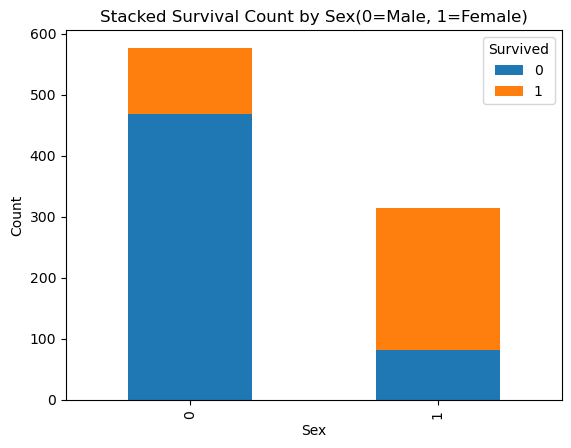

In [32]:
sex_survival = pd.crosstab(df_train['Sex'], df_train['Survived'])
sex_survival.plot(kind='bar', stacked=True)
plt.title("Stacked Survival Count by Sex(0=Male, 1=Female)")
plt.ylabel("Count")
plt.show()

(array([337., 182., 147.,  50.,  16.,  39.,  18.,  29.,  18.,   2.,   8.,
          7.,   0.,   7.,   9.,   0.,   2.,   0.,   0.,   0.,   4.,   1.,
          4.,   0.,   2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.]),
 array([  0.       ,   2.0493168,   4.0986336,   6.1479504,   8.1972672,
         10.246584 ,  12.2959008,  14.3452176,  16.3945344,  18.4438512,
         20.493168 ,  22.5424848,  24.5918016,  26.6411184,  28.6904352,
         30.739752 ,  32.7890688,  34.8383856,  36.8877024,  38.9370192,
         40.986336 ,  43.0356528,  45.0849696,  47.1342864,  49.1836032,
         51.23292  ,  53.2822368,  55.3315536,  57.3808704,  59.4301872,
         61.479504 ,  63.5288208,  65.5781376,  67.6274544,  69.6767712,
         71.726088 ,  73.7754048,  75.8247216,  77.8740384,  79.9233552,
         81.972672 ,  84.0219888,  86.0713056,  88.1206224,  90.1699392,
 

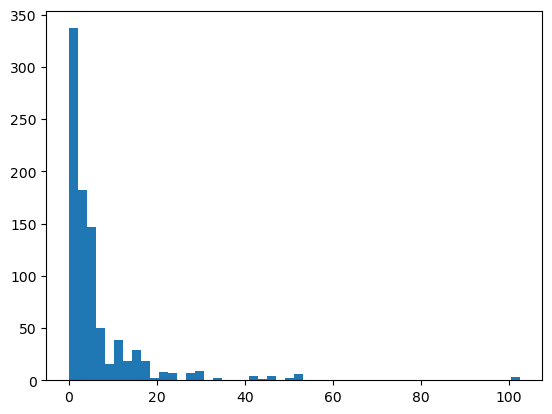

In [125]:
plt.hist(df_train['Fare'] **1/5, bins=50)

In [89]:
df_train[(df_train['Age'] == 5) & (df_train['Parch'] == 0)]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone
619,778,1,3,"Emanuel, Miss. Virginia Ethel",1,5.0,0,0,364516,12.475,NaN,train,0,1,1,1


- Males dominated in total count but females had the most survival rate.

In [34]:
print("Rate of Survival","\n",df_train.pivot_table(index='Sex', values='Survived', aggfunc='mean'))

Rate of Survival 
      Survived
Sex          
0    0.188908
1    0.742038


### -  Pclass Feature(categorical)

In [36]:
df_train["Pclass"].value_counts(normalize=True)

Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64

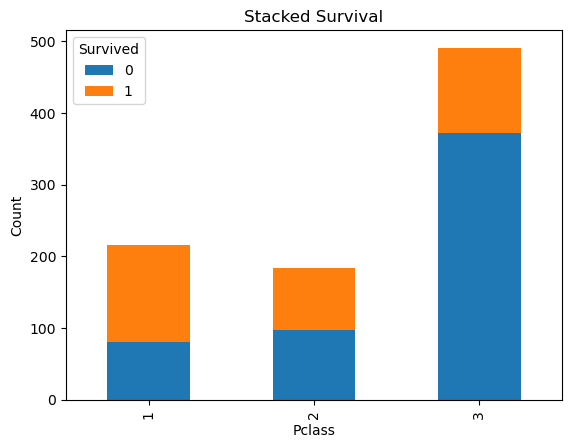

In [37]:
Pclass_sur = pd.crosstab(df_train['Pclass'], df_train['Survived'])
Pclass_sur.plot(kind='bar', stacked=True)
plt.title("Stacked Survival")
plt.ylabel("Count")
plt.show()

In [38]:
print(df_train.pivot_table(index = 'Pclass', values = 'Survived', aggfunc='mean'))

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


- The class 3 was highest in count but lowest comparitively in survival whereas class 1 has highest survival.

### Age Feature(numerical)

#### Age distribution with survival

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


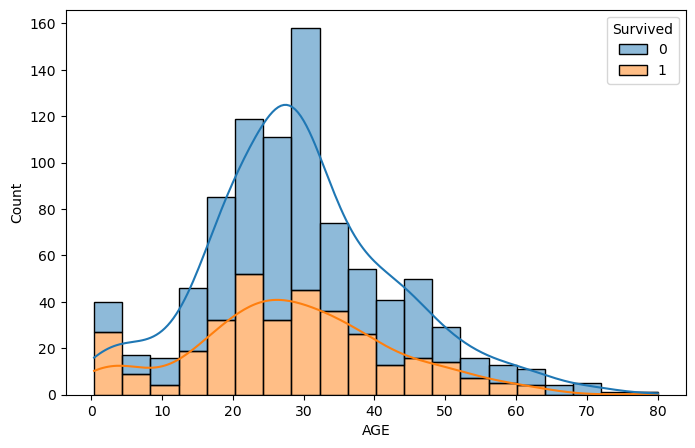

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(data = df_train, x= 'Age', hue = 'Survived', bins = 20, kde=True, multiple = 'stack')

plt.xlabel("AGE")
plt.ylabel("Count")
plt.show()

- The age is distributed widely, as a new feature, we can add age groups as child, Teen,Young Adult, Adult, Middle Aged, Senior to the data.

#### A new feature AgeGroup 
    - (0-12:Child, 12-18: Teen, 18-25: YoungAdult, 25-37: Adult,37-60: MiddleAged, 60-110: Senior)

In [45]:
def Age_Group(df):
    df = df.copy()
    
    bins = [0, 12, 18, 25, 37, 60, 110]
    labels = ['child', 'teen', 'youngadult', 'adult', 'middleaged', 'senior']
    
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    df['AgeGroup'] = pd.Categorical(df['AgeGroup'], categories=labels, ordered=True)
    df['AgeGroup_Encoded'] = df['AgeGroup'].cat.codes
    
    return df.drop(columns= 'AgeGroup')

In [46]:
added_combined = Age_Group(finally_combined)
added_combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone,AgeGroup_Encoded
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,train,0,1,1,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,train,0,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,train,0,1,1,1,3


In [47]:
def fare_group(df):
    df=df.copy()
    df['Fare_bin'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])
    df['Fare_bin'] = df['Fare_bin'].astype(int)
    return df



In [48]:
com_df = fare_group(added_combined)
com_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,source,Embarked_Q,Embarked_S,FamilySize,IsAlone,AgeGroup_Encoded,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,train,0,1,2,0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,train,0,0,2,0,4,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,train,0,1,1,1,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,train,0,1,2,0,3,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,train,0,1,1,1,3,2


In [49]:
training_df = com_df[com_df['source'] == 'train'].drop(columns=['source'])
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,FamilySize,IsAlone,AgeGroup_Encoded,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,2,0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0,2,0,4,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,2,0,3,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,1,3,2


In [61]:
final_features = ['Pclass','Age', 'Sex','SibSp','Parch', 'Fare', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'IsAlone', 'AgeGroup_Encoded', 'Fare_bin']

X_final_train = training_df[final_features]
y_final_train = training_df['Survived']
testing_df = com_df[com_df['source'] == 'test'].drop(columns=['source','Survived'])

X_final_test = testing_df[final_features]




#### Applying tree based models and comparing the performance using cross_val_score and StratifiedKFold

- n_splits = 5

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier


rfc = RandomForestClassifier(n_estimators = 200, random_state=1)

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=1)

cvscores = cross_val_score(rfc, X_final_train,y_final_train, cv = skf, scoring = 'accuracy')


print("Validation scores for each fold:", cvscores)
print("Average accuracy:", cvscores.mean())

Validation scores for each fold: [0.81005587 0.83707865 0.78089888 0.80898876 0.79775281]
Average accuracy: 0.8069549934090766


In [66]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

cvscores = cross_val_score(xgb, X_final_train,y_final_train, cv = skf, scoring = 'accuracy')


print("Validation scores for each fold:", cvscores)
print("Average accuracy:", cvscores.mean())

Validation scores for each fold: [0.82122905 0.82022472 0.78089888 0.83707865 0.80337079]
Average accuracy: 0.812560416797439


In [162]:
xgb.fit(X_final_train, y_final_train)
y_pred = xgb.predict(X_final_test)

submission = pd.DataFrame({"PassengerId": testing_df["PassengerId"], "Survived": y_pred})
submission.to_csv('submission101.csv', index=False)


In [ ]:
rfc.fit(X_final_train, y_final_train)
y_pred = xgb.predict(X_final_test)





In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scale_cols = ['Age', 'Fare', 'FamilySize']
sc = StandardScaler()

sc.fit(X_final_train[scale_cols])

X_train_std = pd.DataFrame(
    sc.transform(X_final_train[scale_cols]),
    columns=scale_cols,
    index=X_final_train.index
)
X_test_std = pd.DataFrame(
    sc.transform(X_final_test[scale_cols]),
    columns=scale_cols,
    index=X_final_test.index
)

X_train_processed = pd.concat([X_train_std, X_final_train.drop(columns=scale_cols)], axis=1)
X_test_processed = pd.concat([X_test_std, X_final_test.drop(columns=scale_cols)], axis=1)

lr = LogisticRegression(C= 1.0,solver = 'lbfgs', max_iter=1000, random_state=1) 
cvscores = cross_val_score(lr, X_train_processed,y_final_train, cv = skf, scoring = 'accuracy')

print("Validation scores for each fold:", cvscores)
print("Average accuracy:", cvscores.mean())

Validation scores for each fold: [0.77653631 0.82022472 0.80337079 0.83707865 0.79213483]
Average accuracy: 0.8058690603226413


In [82]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_train = xgb.predict(X_final_train)
print(confusion_matrix(y_final_train, y_pred_train))
print(classification_report(y_final_train, y_pred_train))

[[511  38]
 [ 75 267]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       549
           1       0.88      0.78      0.83       342

    accuracy                           0.87       891
   macro avg       0.87      0.86      0.86       891
weighted avg       0.87      0.87      0.87       891



In [130]:
from sklearn.svm import SVC
#103

svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_processed,y_final_train,cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.84269663 0.8258427  0.83146067 0.84269663]
0.8271985437197916


In [176]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators = [('rfc',rfc), ('xgb',xgb)], voting = 'soft') 

In [178]:
cvscore = cross_val_score(voting,X_train_processed,y_final_train,cv = skf, scoring = 'accuracy')
print(cvscore)
print(cvscore.mean())

[0.84357542 0.83707865 0.78651685 0.83146067 0.8258427 ]
0.8248948590797817


In [180]:
voting.fit(X_train_processed,y_final_train)
y_pred = voting.predict(X_test_processed)

submission = pd.DataFrame({"PassengerId": testing_df["PassengerId"], "Survived": y_pred})
submission.to_csv('submission102.csv', index=False)


In [ ]:
svc.fit(X_train_processed,y_final_train)
y_pred = svc.predict(X_test_processed)

submission = pd.DataFrame({"PassengerId": testing_df["PassengerId"], "Survived": y_pred})
submission.to_csv('submission103.csv', index=False)
